In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as keras
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
train_df = pd.read_csv("../data/train.csv")
val_df = pd.read_csv("../data/validation.csv")
test_df = pd.read_csv("../data/test.csv")

In [3]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_df["Comment_Adj"])
tokenizer.fit_on_texts(val_df["Comment_Adj"])
X_train = tokenizer.texts_to_sequences(train_df["Comment_Adj"])
X_val = tokenizer.texts_to_sequences(val_df["Comment_Adj"])

vocab_size = len(tokenizer.word_index) + 1

maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["Result_Bin"])
y_val = label_encoder.fit_transform(val_df["Result_Bin"])

In [4]:
def set_all_seeds(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_all_seeds(42)

def CNN_model_adj(filter=16, kernel=4, num_1=40, lr=0.01, dropout_rate=0.5):
    set_all_seeds(42)
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=200, 
                               input_length=maxlen))
    model.add(Conv1D(filters=filter, kernel_size=kernel, activation="relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_1, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


filters = [16, 32, 48]
kernels = [4, 6]
num_1 = [40, 70, 100]
lrs = [0.01, 0.001]
dropout_rate = [0.5, 0.6]

best_accuracy = 0
best_history = None
best_model_desc = ""
best_model_cnn = None

for filter in filters:
    for kernel in kernels:
        for num in num_1:
            for lr in lrs:
                for rate in dropout_rate:
                    model_desc = f"filter = {filter}, kernel = {kernel}, num_1 = {num}, lr = {lr}, dropout_rate = {rate}"
                    print("Training model with configuration:", model_desc)
                    model = CNN_model_adj(filter = filter, kernel = kernel, num_1 = num, lr = lr, dropout_rate = rate)
                    history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=False,
                    validation_data=(X_val, y_val),
                    batch_size=1000, callbacks = [early_stopping])
                    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=False)
                    print(f"Validation Accuracy: {val_accuracy:.4f}")

                    if val_accuracy > best_accuracy:
                        best_accuracy = val_accuracy
                        best_history = history
                        best_model_desc = model_desc
                        best_model_cnn = model


print(f"The best model has parameters: {best_model_desc} with accuracy = {round(best_accuracy, 4)}.")

Training model with configuration: filter = 16, kernel = 4, num_1 = 40, lr = 0.01, dropout_rate = 0.5


2024-04-25 23:55:42.771928: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Validation Accuracy: 0.5883
Training model with configuration: filter = 16, kernel = 4, num_1 = 40, lr = 0.01, dropout_rate = 0.6
Validation Accuracy: 0.6041
Training model with configuration: filter = 16, kernel = 4, num_1 = 40, lr = 0.001, dropout_rate = 0.5
Validation Accuracy: 0.6344
Training model with configuration: filter = 16, kernel = 4, num_1 = 40, lr = 0.001, dropout_rate = 0.6
Validation Accuracy: 0.6375
Training model with configuration: filter = 16, kernel = 4, num_1 = 70, lr = 0.01, dropout_rate = 0.5
Validation Accuracy: 0.6191
Training model with configuration: filter = 16, kernel = 4, num_1 = 70, lr = 0.01, dropout_rate = 0.6
Validation Accuracy: 0.6033
Training model with configuration: filter = 16, kernel = 4, num_1 = 70, lr = 0.001, dropout_rate = 0.5
Validation Accuracy: 0.6221
Training model with configuration: filter = 16, kernel = 4, num_1 = 70, lr = 0.001, dropout_rate = 0.6
Validation Accuracy: 0.6252
Training model with configuration: filter = 16, kernel = 4

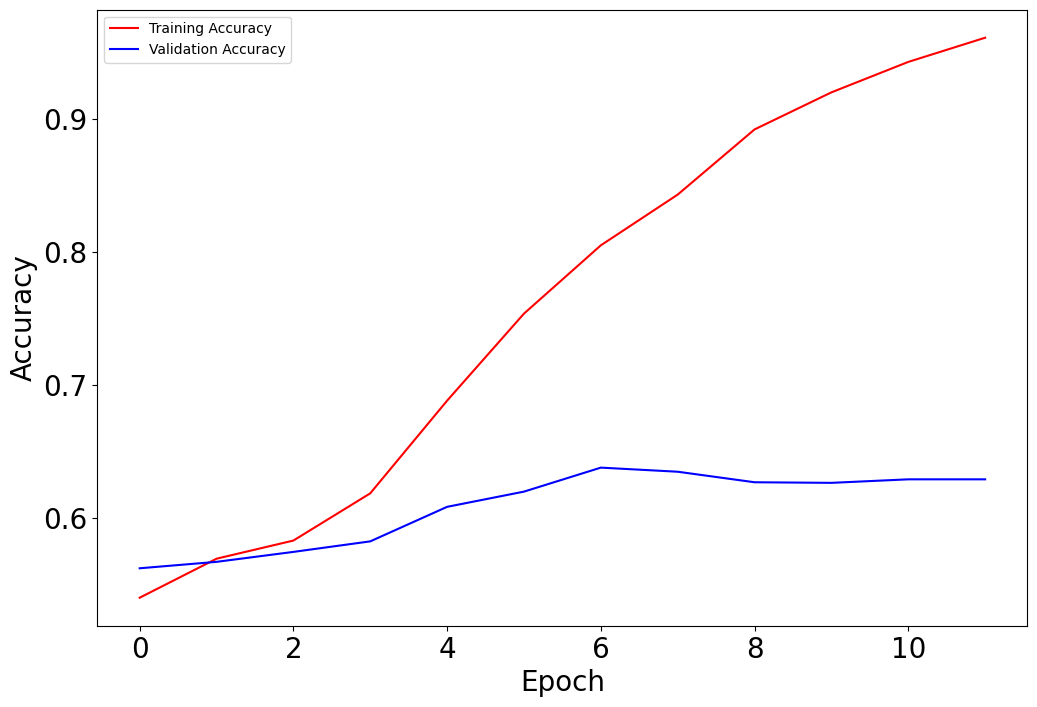

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(best_history.history['accuracy'], 'r', label='Training Accuracy')
ax.plot(best_history.history['val_accuracy'], 'b' ,label='Validation Accuracy')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [1]:
predictions = best_model_cnn.predict(X_val)
predictions = (predictions > 0.5).astype(int) 

f1 = f1_score(y_val, predictions)
print("F1 Score:", round(f1,3))
# Calculate Precision
precision = precision_score(y_val, predictions)
print("Precision:", round(precision, 3))
# Calculate recall
recall = recall_score(y_val, predictions)
print("Recall:", round(recall, 3))

NameError: name 'best_model_cnn' is not defined

In [2]:
conf_matrix = confusion_matrix(y_val, predictions)

plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = [0,1])
cm_display.plot()

NameError: name 'confusion_matrix' is not defined

In [18]:
tokenizer.fit_on_texts(test_df["Comment_Adj"])
X_test = tokenizer.texts_to_sequences(test_df["Comment_Adj"])

X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(test_df["Result_Bin"])

predictions = best_model_cnn.predict(X_test)
predictions = (predictions > 0.5).astype(int) 

f1 = f1_score(y_test, predictions)
print("F1 Score:", round(f1,3))
# Calculate Precision
precision = precision_score(y_test, predictions)
print("Precision:", round(precision, 3))
# Calculate recall
recall = recall_score(y_test, predictions)
print("Recall:", round(recall, 3))

72/72 [==============================] - 0s 2ms/step
F1 Score: 0.618
Precision: 0.579
Recall: 0.662


<Figure size 800x600 with 0 Axes>

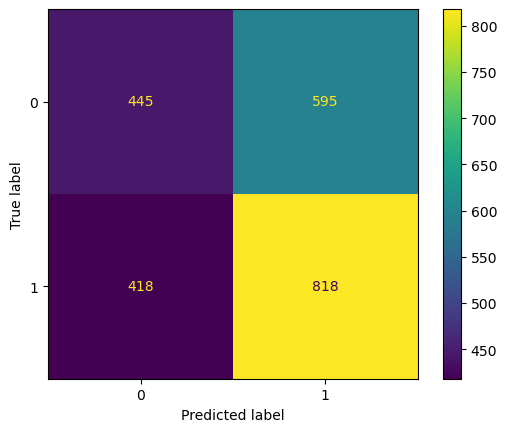

In [19]:
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = [0,1])
cm_display.plot()